# Class Activation Maps with Fashion MNIST

In this notebook, we will implement a simple class activation map (CAM) for a model trained on the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). This will highlight the parts of the image the model focused on when deciding the class of the image.

## Imports

In [ ]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import scipy as sp

## Download and Prepare the Data

In [ ]:
# Load the Fashion MNIST dataset
(X_train,Y_train),(X_test,Y_test)  = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Put an additional axis for the channels of the image.
# Fashion MNIST is grayscale so we place 1 at the end. Other datasets will need 3 if it's in RGB.
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

# Normalize the pixel values from 0 to 1
X_train = X_train/255
X_test  = X_test/255

# Cast to float
X_train = X_train.astype('float')
X_test  = X_test.astype('float')

In [ ]:
def show_img(img):
    '''utility function for reshaping and displaying an image'''

    # Convert to float array if img is not yet preprocessed
    img  = np.array(img,dtype='float')

    # Remove channel dimension
    img = img.reshape((28,28))

    # Display image
    plt.imshow(img)

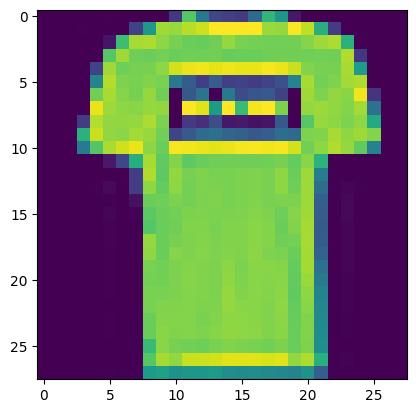

In [ ]:
# Show first training image
show_img(X_train[1])

## Build the Classifier

In [ ]:
# Use the Sequential API
model = Sequential()

# Add the first convolution layer
model.add(Conv2D(16,input_shape=(28,28,1),kernel_size=(3,3),activation='relu',padding='same'))

# Add a pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Add subsequent conv2d layers followed by max pooling layers
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))

# Global average pooling to take into account lesser intensity pixels
model.add(GlobalAveragePooling2D())

# Output class probabilities
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

### Train the Model

In [ ]:
# Compile and train the model
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

model.fit(X_train,Y_train,batch_size=32, epochs=5, validation_split=0.1, shuffle=True)

Epoch 1/5
1688/1688 [==============================] - 21s 7ms/step - loss: 0.6125 - accuracy: 0.7722 - val_loss: 0.4163 - val_accuracy: 0.8507
Epoch 2/5
1688/1688 [==============================] - 9s 5ms/step - loss: 0.3728 - accuracy: 0.8653 - val_loss: 0.3224 - val_accuracy: 0.8842
Epoch 3/5
1688/1688 [==============================] - 9s 5ms/step - loss: 0.3157 - accuracy: 0.8872 - val_loss: 0.2897 - val_accuracy: 0.8972
Epoch 4/5
1688/1688 [==============================] - 8s 5ms/step - loss: 0.2800 - accuracy: 0.8987 - val_loss: 0.2775 - val_accuracy: 0.8993
Epoch 5/5
1688/1688 [==============================] - 9s 5ms/step - loss: 0.2566 - accuracy: 0.9063 - val_loss: 0.2684 - val_accuracy: 0.9058


## Generate the Class Activation Map

To generate the class activation map, we need to obtain the features detected in the last convolution layer and identify which ones are most active when generating the output probabilities. In our model, we are particularly interested in the layers highlighted below.

In [ ]:
# Print the name of the final convolution layer
print(model.layers[-3].name)

# Print the name of the global average pooling layer
print(model.layers[-2].name)

# Print the name of the output of the classifier
print(model.layers[-1].name)

conv2d_3
global_average_pooling2d
dense


We can now create our CAM model as shown below.

In [ ]:
# Same as previous model but with an additional output
cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496 

Use the CAM model to predict on the test set, so that it generates the features and the predicted probability for each class (`results`).

In [ ]:
# Obtain the features and results of the test images using the newly created model.
features,results = cam_model.predict(X_test)

# Print the shape of the features
print("features shape: ", features.shape)
print("results shape", results.shape)

313/313 [==============================] - 1s 3ms/step
features shape:  (10000, 3, 3, 128)
results shape (10000, 10)


To generate the CAM, we need to calculate the dot product of the class activation features and the class activation weights.

We'll need the weights from the Global Average Pooling (GAP) layer to calculate the activations of each feature for a particular class:
- These weights are obtained from the dense layer that follows the GAP layer.
  - The last Conv2D layer has dimensions (h, w, depth) of (3 x 3 x 128), so there are 128 features.
  - The GAP layer collapses the (3 x 3 x 128) features into a dense layer of 128 neurons (1 neuron per feature).
  - The activations from the GAP layer are passed to the final dense layer.
  - The final dense layer assigns weights to each of the 128 features for each of the 10 classes.
  - Thus, the weights of the final dense layer, which follows the GAP layer, are referred to as the "weights of the global average pooling layer."

For each of the 10 classes, there are 128 features, resulting in 128 feature weights, one for each feature.

In [ ]:
# Extract the weights going into the softmax layer
last_dense_layer = model.layers[-1]

# Retrieve the weights list. Index 0 contains the weights, and index 1 contains the biases.
gap_weights_l = last_dense_layer.get_weights()

print("gap_weights_l index 0 contains weights ", gap_weights_l[0].shape)
print("gap_weights_l index 1 contains biases ", gap_weights_l[1].shape)

# This shows the number of features per class and the total number of classes.
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")

gap_weights_l index 0 contains weights  (128, 10)
gap_weights_l index 1 contains biases  (10,)
There are 128 feature weights and 10 classes.


Now, retrieve the features for a specific image, indexed between 0 and 999.

In [ ]:
# Get the features for the image at index 0
idx = 0
features_for_img = features[idx,:,:,:]

print(f"The features for image index {idx} has shape (height, width, num of feature channels) : ", features_for_img.shape)

The features for image index 0 has shape (height, width, num of feature channels) :  (3, 3, 128)


The features have height and width of 3 by 3.  Scale them up to the original image height and width, which is 28 by 28.

In [ ]:
features_for_img_scaled = sp.ndimage.zoom(features_for_img, (28/3, 28/3,1), order=2)

# Check the shape after scaling up to 28 by 28 (still 128 feature channels)
print("features_for_img_scaled up to 28 by 28 height and width:", features_for_img_scaled.shape)

features_for_img_scaled up to 28 by 28 height and width: (28, 28, 128)


For a particular class (0...9), obtain the 128 weights.

Take the dot product of the scaled features for the selected image with these weights.

The shapes are:
- Scaled features: (h, w, depth) of (28 x 28 x 128).
- Weights for one class: 128.

The dot product produces the class activation map, with the resulting shape equal to the height and width of the image: 28 x 28.

In [ ]:
# Select the weights that are used for a specific class (0...9)
class_id = 0
# take the dot product between the scaled image features and the weights for
gap_weights_for_one_class = gap_weights[:,class_id]

print("features_for_img_scaled has shape ", features_for_img_scaled.shape)
print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)
# take the dot product between the scaled features and the weights for one class
cam = np.dot(features_for_img_scaled, gap_weights_for_one_class)

print("class activation map shape ", cam.shape)

features_for_img_scaled has shape  (28, 28, 128)
gap_weights_for_one_class has shape  (128,)
class activation map shape  (28, 28)


### Conceptual interpretation

To conceptualize what we're doing and why:
- In the 28 x 28 x 128 feature map, each of the 128 feature filters is designed to detect specific sets of features (for example, a shoelace).
  - These features are learned by the model, not manually selected.
- Each of the 128 weights for a particular class determines the importance of each of the 128 features for that class.
  - For instance, for the "shoe" class, the weights may be higher for feature filters that detect shoelaces.
- At each of the 28 by 28 pixels, we can take the vector of 128 features and compare them with the vector of 128 weights.
  - This comparison is done using a dot product.
  - The dot product results in a scalar value at each pixel.
  - Apply this dot product across all of the 28 x 28 pixels.
  - The scalar result of the dot product will be larger when the image both has the particular feature (e.g., a shoelace), and that feature is also weighted more heavily for the particular class (e.g., shoe).
  
Thus, we create a matrix with the same number of pixels as the image, where the value at each pixel is higher when that pixel is relevant to the prediction of a particular class.

Here is the function that implements the Class activation map calculations.

In [ ]:
def show_cam(image_index):
  '''displays the class activation map of a particular image'''

  # takes the features of the chosen image
  features_for_img = features[image_index,:,:,:]

  # get the class with the highest output probability
  prediction = np.argmax(results[image_index])

  # get the gap weights at the predicted class
  class_activation_weights = gap_weights[:,prediction]

  # upsample the features to the image's original size (28 x 28)
  class_activation_features = sp.ndimage.zoom(features_for_img, (28/3, 28/3, 1), order=2)

  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(results[image_index][prediction]))

  # show the upsampled image
  plt.imshow(np.squeeze(X_test[image_index],-1), alpha=0.5)

  # strongly classified (95% probability) images will be in green, else red
  if results[image_index][prediction]>0.95:
    cmap_str = 'Greens'
  else:
    cmap_str = 'Reds'

  # overlay the cam output
  plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

  # display the image
  plt.show()

We can now test generating class activation maps. Use the following utility function for this purpose.

In [ ]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates CAMs
    for the first `num_maps`(int) of the `desired_class`(int)
    '''

    counter = 0

    if desired_class < 10:
        print("please choose a class less than 10")

    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i)

For class 8 (handbag), notice that most of the images have dark spots in the middle and right side.
- This means these areas were given less importance when categorizing the image.
- Other parts, such as the outline or handle, contribute more when deciding if an image is a handbag or not.

Observe the other classes to see if there are common areas that the model uses more in determining the class of the image.

please choose a class less than 10
Predicted Class = 7, Probability = 0.9999255


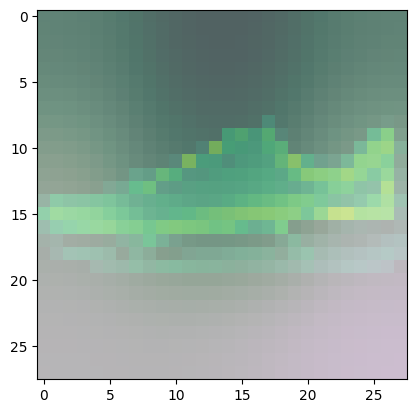

Predicted Class = 7, Probability = 0.68172383


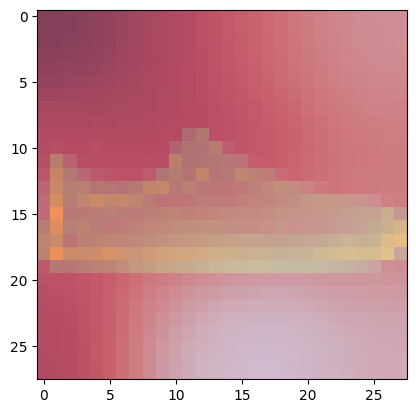

Predicted Class = 7, Probability = 0.9318354


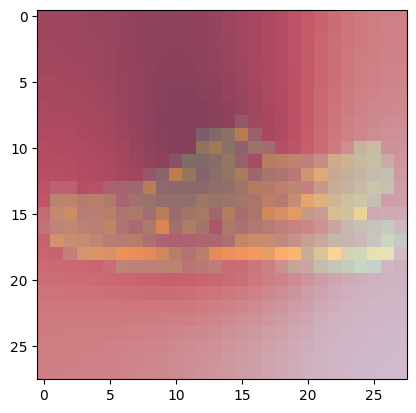

Predicted Class = 7, Probability = 0.9999187


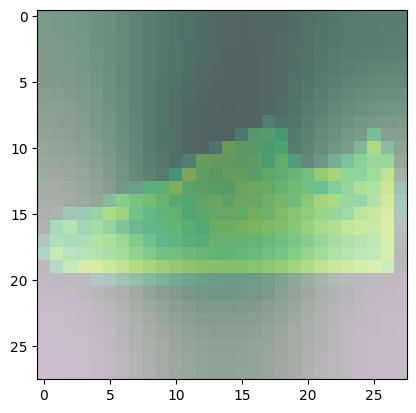

Predicted Class = 7, Probability = 0.9999949


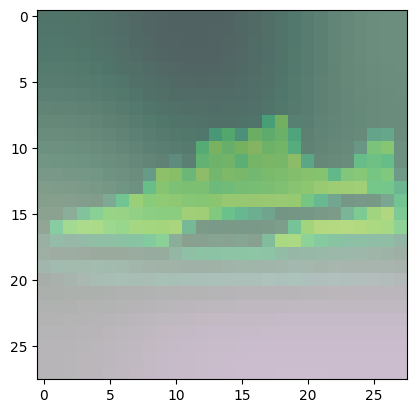

Predicted Class = 7, Probability = 0.9998784


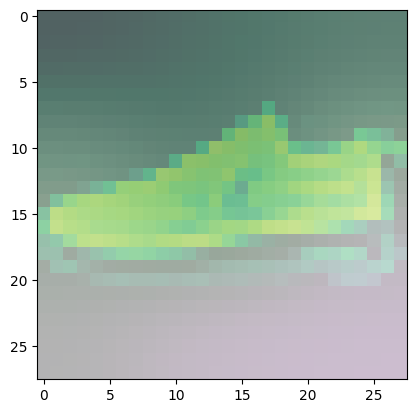

Predicted Class = 7, Probability = 0.6548428


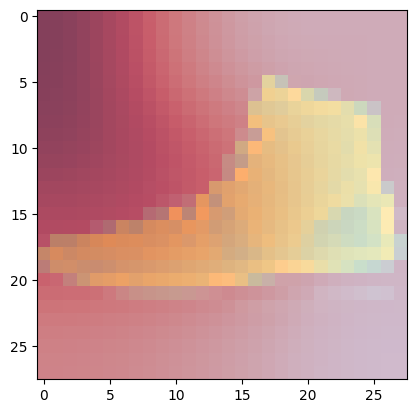

Predicted Class = 7, Probability = 0.96639544


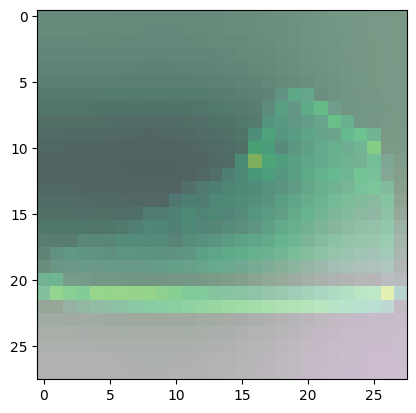

Predicted Class = 7, Probability = 0.9995571


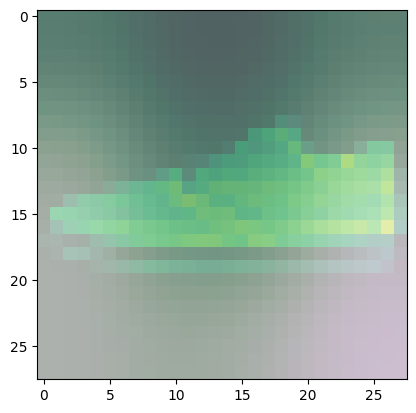

Predicted Class = 7, Probability = 0.995741


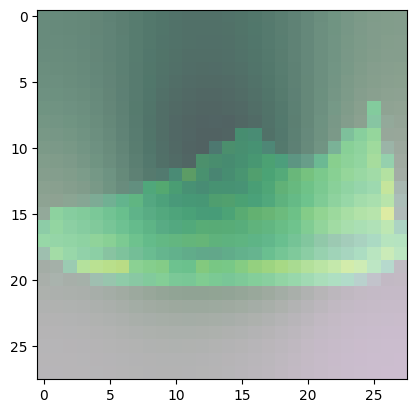

Predicted Class = 7, Probability = 0.98710585


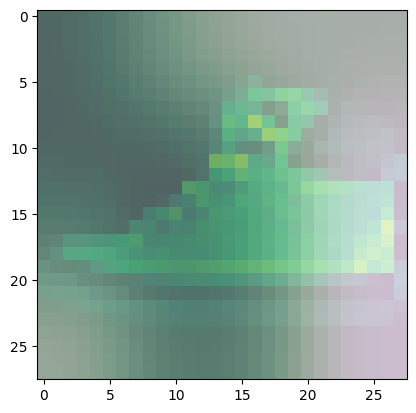

Predicted Class = 7, Probability = 0.9995338


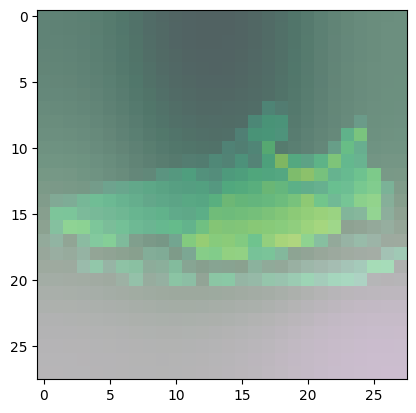

Predicted Class = 7, Probability = 0.999869


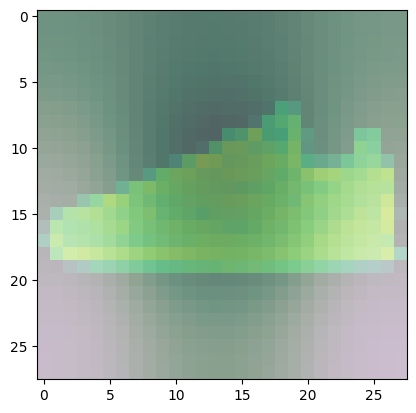

Predicted Class = 7, Probability = 0.99994504


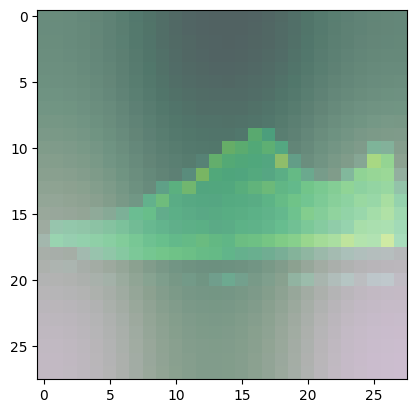

Predicted Class = 7, Probability = 0.99976605


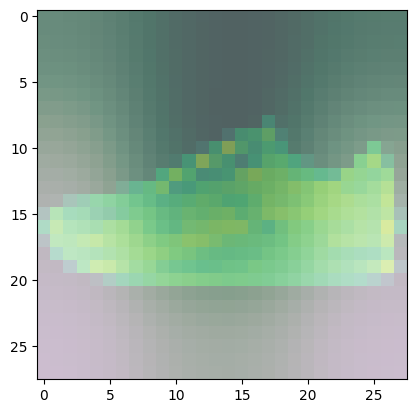

Predicted Class = 7, Probability = 0.8898345


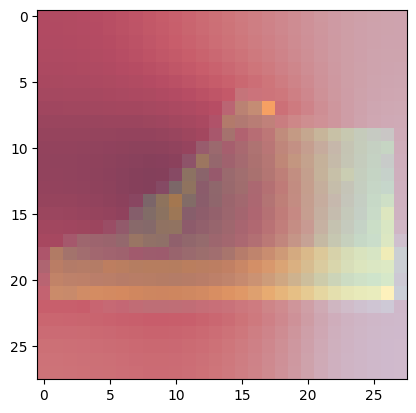

Predicted Class = 7, Probability = 0.9998894


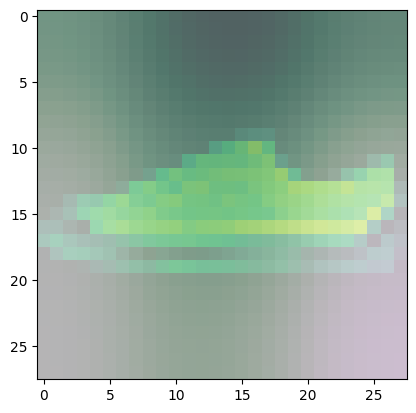

Predicted Class = 7, Probability = 0.99783236


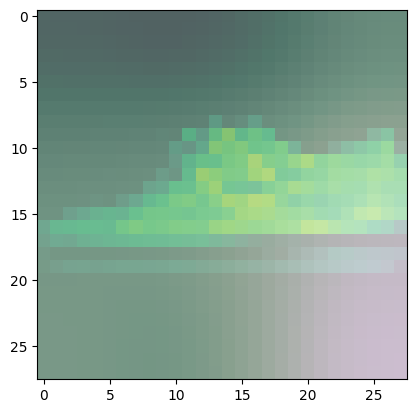

Predicted Class = 7, Probability = 0.9997421


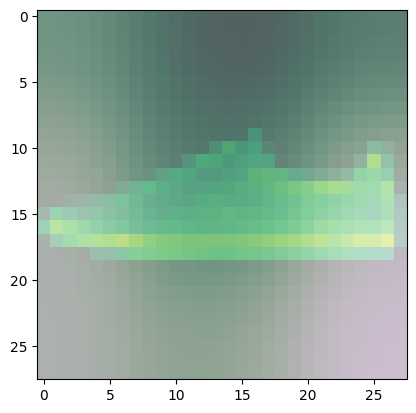

Predicted Class = 7, Probability = 0.999561


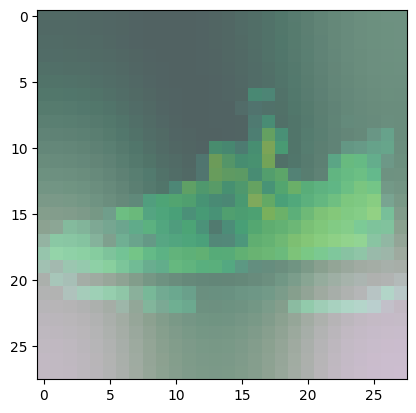

In [ ]:
show_maps(desired_class=7, num_maps=20)